# Importations 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns  

# Pytorch 
import torch 
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import transformers 


#sklearn
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing  
from sklearn import model_selection
from sklearn import metrics

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
import time, gc 

torch.manual_seed(0)
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
data = pd.read_csv('../input/chicago-traffic/chicago.csv')
data["TIME"]=pd.to_datetime(data["TIME"], format="%m/%d/%Y %H:%M:%S %p")
data.drop(data[data['SPEED']==0].index,inplace =True)
data['day'] = data['TIME'].dt.day
data['MONTH'] = data['TIME'].dt.month
data['YEAR'] = data['TIME'].dt.year
data = data.groupby(['REGION_ID','HOUR','MONTH','day', 'WEST','EAST', 'SOUTH','NORTH','DAY_OF_WEEK','YEAR'])[['SPEED','BUS_COUNT','NUM_READS']].agg('mean').reset_index()
data['CENTER_LAT']=data['NORTH']*0.5+0.5*data['SOUTH']
data['CENTER_LON']=data['EAST']*0.5+0.5*data['WEST']

## Feature engineering and handling Location data 

In [3]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [4]:
def width(x) : 
    return haversine_array(x['NORTH'],x['WEST'],x['NORTH'],x['EAST'])
def length(x) : 
    return haversine_array(x['NORTH'],x['EAST'],x['SOUTH'],x['EAST'])

In [5]:
tqdm.pandas()
data['length'] =  data[['WEST','EAST', 'SOUTH','NORTH']].progress_apply(length,axis=1)
data['width']  =  data[['WEST','EAST', 'SOUTH','NORTH']].progress_apply(width,axis=1)

In [6]:
data['area'] = data['length']*data['width']
data['reders_per_area'] = data['BUS_COUNT']/data['area'] 
data['READS_per_area'] = data['NUM_READS']/data['area'] 
data['BUS_ratio'] = data['BUS_COUNT']/data['NUM_READS'] 

# Data preprocessing


In [7]:
data['MINUTE'] = '00'
data['Time'] = pd.to_datetime(data[['YEAR','MONTH','day','HOUR','MINUTE']].astype(str).agg('-'.join,axis=1),format='%Y-%m-%d-%H-%M')

In [8]:
categorical_features = ['REGION_ID','MONTH','HOUR','day','DAY_OF_WEEK','YEAR']
LSTM = ['HOUR','DAY_OF_WEEK']
Numerical_features = ['NUM_READS','BUS_COUNT','area','length','width','CENTER_LAT','CENTER_LON','reders_per_area','READS_per_area','BUS_ratio']

In [9]:
from sklearn.preprocessing import StandardScaler
for i in Numerical_features : 
    scalar=StandardScaler()
    scalar.fit(data[i].values.reshape(-1, 1))
    data[i]=scalar.transform(data[i].values.reshape(-1, 1)) 

In [10]:
for f in categorical_features : 
  label_encoder = preprocessing.LabelEncoder()
  label_encoder.fit(data[f].astype('str'))
  data[f] = label_encoder.transform(data[f].astype('str').fillna('-1'))

## Train valid test split  

In [11]:
df_train ,df_test   = model_selection.train_test_split( data ,test_size = 0.1 ,random_state = 44  )
df_train , df_valid = model_selection.train_test_split( df_train ,test_size = 0.2 ,random_state = 44  )

## Training part 

In [12]:
X_train = df_train.drop(['SPEED','Time','MINUTE'],1) 
val_X   = df_valid.drop(['SPEED','Time','MINUTE'],1) 
y_train = df_train.SPEED
val_y   = df_valid.SPEED

## XGBRegressor

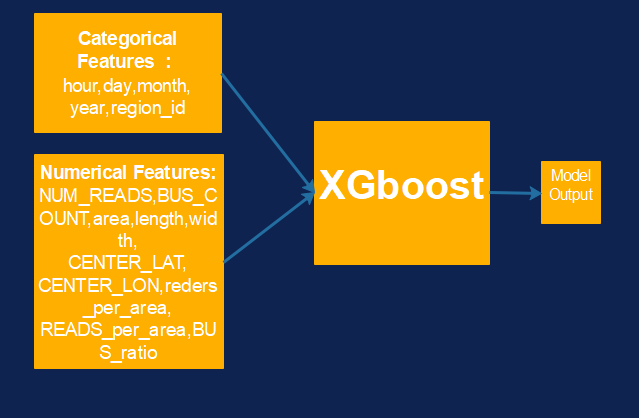

In [13]:
start_time = time.time()
xgboost = XGBRegressor(learning_rate=0.2, n_estimators=50000,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=8,
                                     tree_method='gpu_hist' , 
                                       boosting_type = 'gbdt',
                                       metric = 'rmse'
                                       )
eval_set = [(X_train, y_train), (val_X, val_y)]

xgboost.fit(X_train,y_train,eval_set=eval_set,
         verbose=100, early_stopping_rounds=100)

preds = xgboost.predict(X_train)
val_mae2 =np.sqrt(metrics.mean_squared_error(y_train, preds))
print('train_error',val_mae2)
preds = xgboost.predict(val_X)
val_mae2 =np.sqrt(metrics.mean_squared_error( val_y, preds))
print('vaild_error',val_mae2)

[05:17:33] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20.41434	validation_1-rmse:20.42349
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:1.87997	validation_1-rmse:1.91167
[200]	validation_0-rmse:1.81945	validation_1-rmse:1.85978
[300]	validation_0-rmse:1.78799	validation_1-rmse:1.83979
[400]	validation_0-rmse:1.76650	validation_1-rmse:1.82640
[500]	validation_0-rmse:1.75078	validation_1-rmse:1.81884
[600]	validation_0-rmse:1.73825	validation_1-rmse:1.81281
[700]	validation_0-rmse:1.72774	validation_1-rmse:1.80902
[800]	validation_0-rmse:1.71830	validation_1-rmse:1.80674
[900]	validation_0-rmse:1.71029	validation_1-rmse:1.80486
[1000]	validation_0-rmse:1.70262	validation_1-rmse:1.80381
Stopping. Best iteration:
[939]	validation_0-rmse:1.70753	validation_1-rms

In [14]:
print("total training time is %s Minute " %((time.time() - start_time)/60))
print("hardware : NVidia K80 GPUs ")

total training time is 0.46326645612716677 Minute 
hardware : NVidia K80 GPUs 


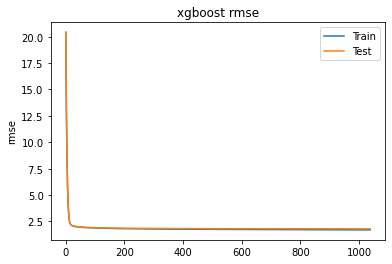

In [15]:
def plot_model(model,name):
  results = model.evals_result()
  fig, ax = plt.subplots()
  epochs = len(results['validation_0']['rmse'])
  x_axis = range(0, epochs)
  ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
  ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
  ax.legend()
  plt.ylabel('rmse')
  plt.title(name+' rmse')
  plt.show()
plot_model(xgboost,'xgboost')

# Model evaluation

In [16]:
X_test = df_test.drop(['SPEED','Time','MINUTE'],1) 
y_test = df_test.SPEED
preds = xgboost.predict(X_test)
val_mae2 =np.sqrt(metrics.mean_squared_error(y_test, preds))
print('TEST RMSE : ',val_mae2)

TEST RMSE :  1.7649290292253976


In [17]:
def plot(region , year , month , day ) : 
    data['year']  = data['Time'].dt.year
    data['month'] = data['Time'].dt.month
    data['days']  = data['Time'].dt.day
    sub_plot = data[(data['REGION_ID']==region)&(data['year']==year)&(data['month']==month)& (data['days']<day)]
    sub_plot = sub_plot.sort_values('Time')
    y=  sub_plot['SPEED'].values
    X = sub_plot.drop(['SPEED','Time','MINUTE','year', 'days', 'month'],1) 
    predictions  =xgboost.predict(X)
    plt.figure(figsize=(24, 8))
    plt.plot(sub_plot['Time'].values , sub_plot['SPEED'].values, '--',label = 'real values')
    plt.plot(sub_plot['Time'].values , predictions,label = 'predicted values')
    plt.ylabel(f'SPEED in region id {region}')
    plt.title(f' predicted vs real values ')
    plt.xlabel('Time')
    plt.grid(True)
    plt.legend()

    plt.show()

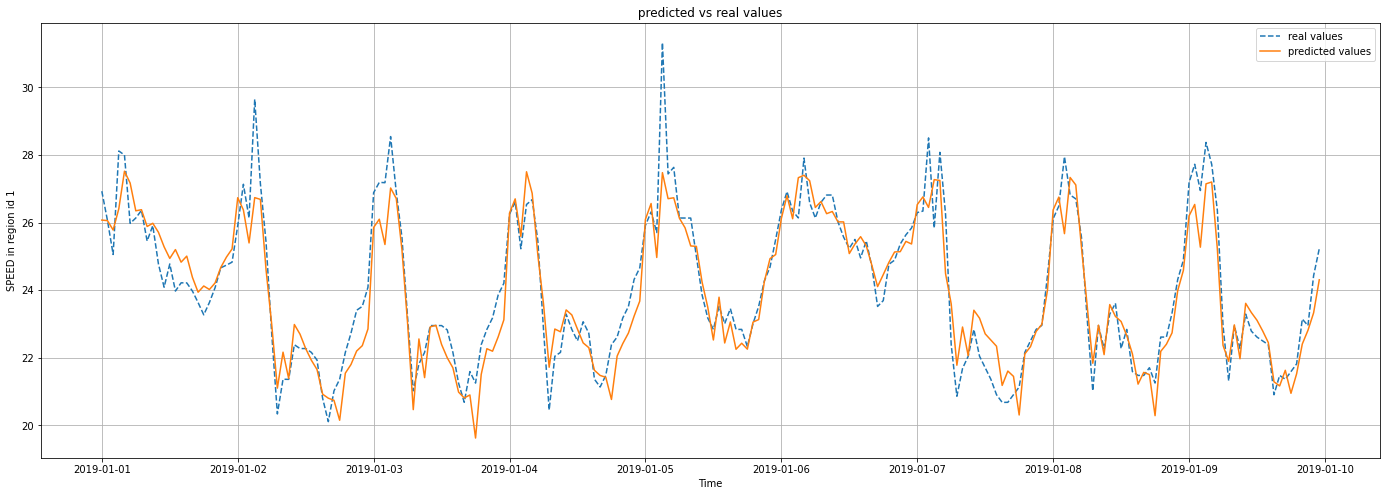

In [18]:
plot(1,2019,1,10)

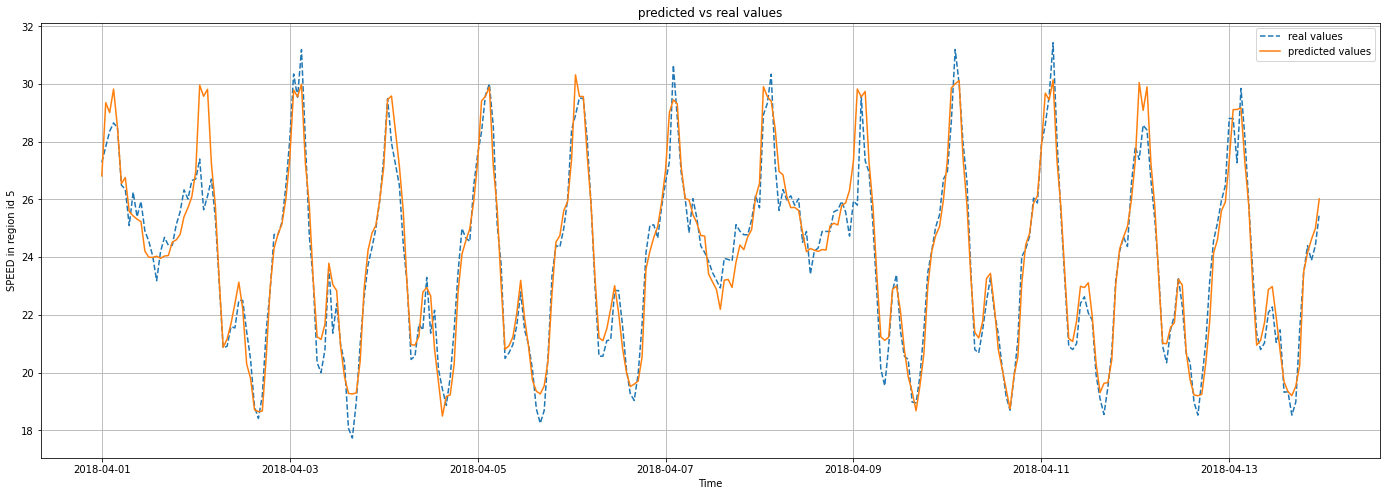

In [19]:
plot(5,2018,4,14)


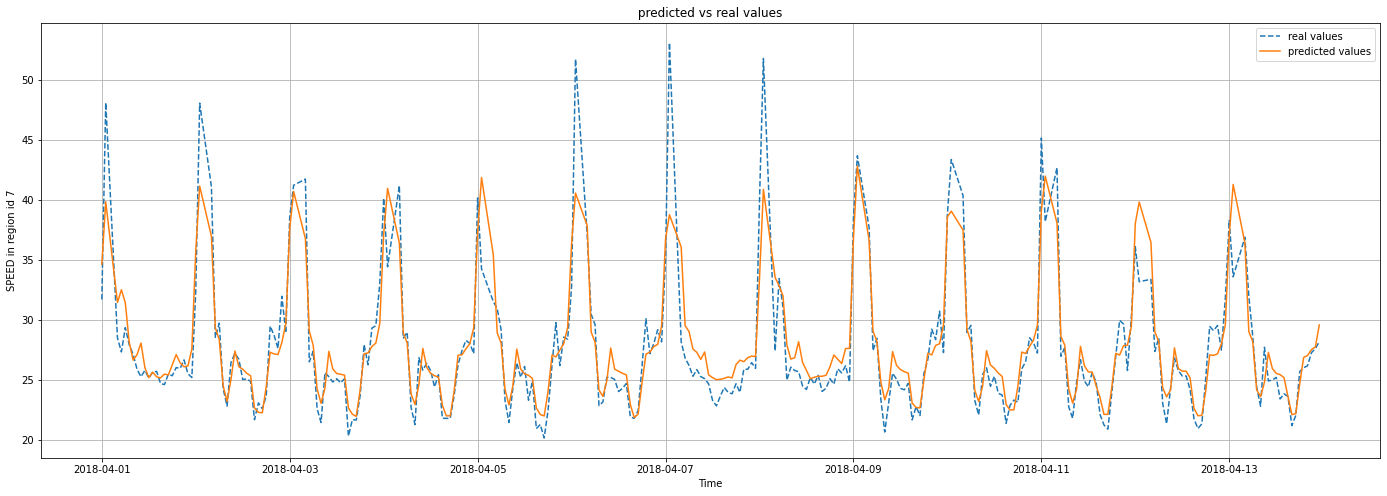

In [20]:
plot(7,2018,4,14)


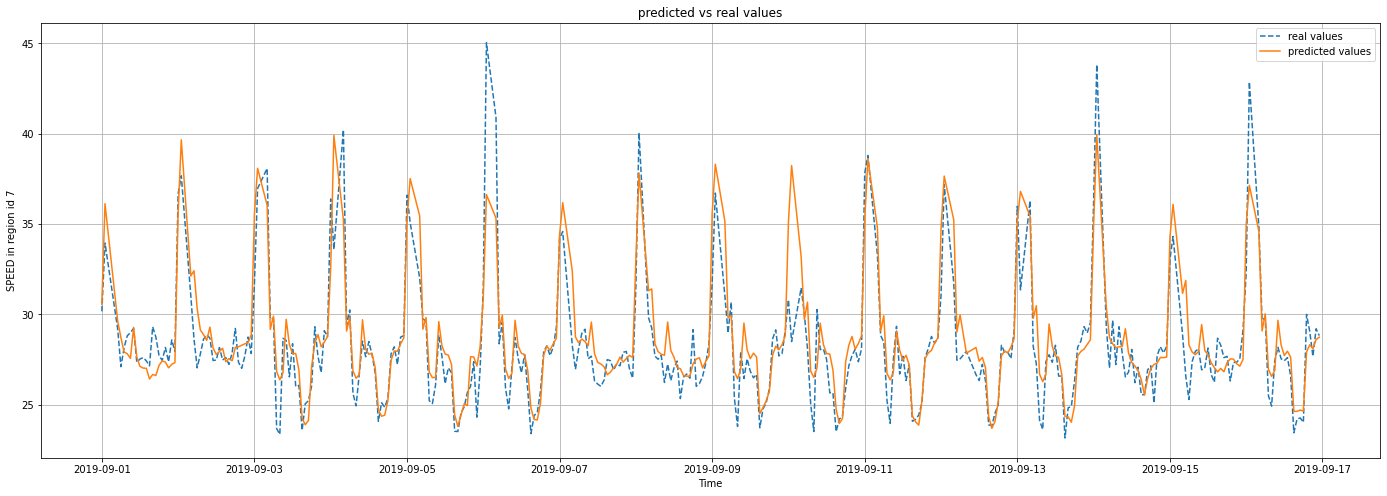

In [21]:
plot(7,2019,9,17)
